# Cell 1: Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from itertools import tee
import pickle as pkl

from matplotlib import ticker
import os

from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

#plt.rcParams.update({"text.usetex": True})
if 0:
    # pairwise for Python < 3.10
    if sys.version_info < (3,10):
        def pairwise(iterable):
            a, b = tee(iterable)
            next(b, None)
            return zip(a, b)
    else:
        from itertools import pairwise

# Cell 2: Load & reshape data into 3D arrays

In [2]:
data_dirs = 'C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\Tianxiang data\\data_new'
save_path = os.path.join(data_dirs, 'figs')
if not os.path.exists(save_path):
    os.makedirs(save_path)
defect_path = os.path.join(data_dirs, 'defect_positions.pkl')
params_path = os.path.join(data_dirs, 'parameters.pkl')
# load
with open(defect_path, 'rb') as f:
    defect_list = pkl.load(f)
with open(defect_path, 'rb') as f:
    params_dict = pkl.load(f)

sfac = np.load(os.path.join(data_dirs, 'sfac.npy'))
#pcf = np.load(os.path.join(data_dirs, 'pcf.npy'))
kbins = np.loadtxt(os.path.join(data_dirs, 'kbins.txt'))
Ndefects = np.loadtxt(os.path.join(data_dirs, 'Ndefects.txt'))
av_counts = np.load(os.path.join(data_dirs, 'av_counts_periodic_rm0.25.npy'))
window_sizes = np.loadtxt(os.path.join(data_dirs, 'window_sizes.txt'))

pcf = np.load(os.path.join(data_dirs, 'pcf_arr.npy'))
rad_arr = np.load(os.path.join(data_dirs, 'rad_arr.npy'))

In [ ]:
pcf.shape, r

(150, 513)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_3212\1049864759.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(rad_arr, np.nanmean(pcf[:50,:], axis=0))


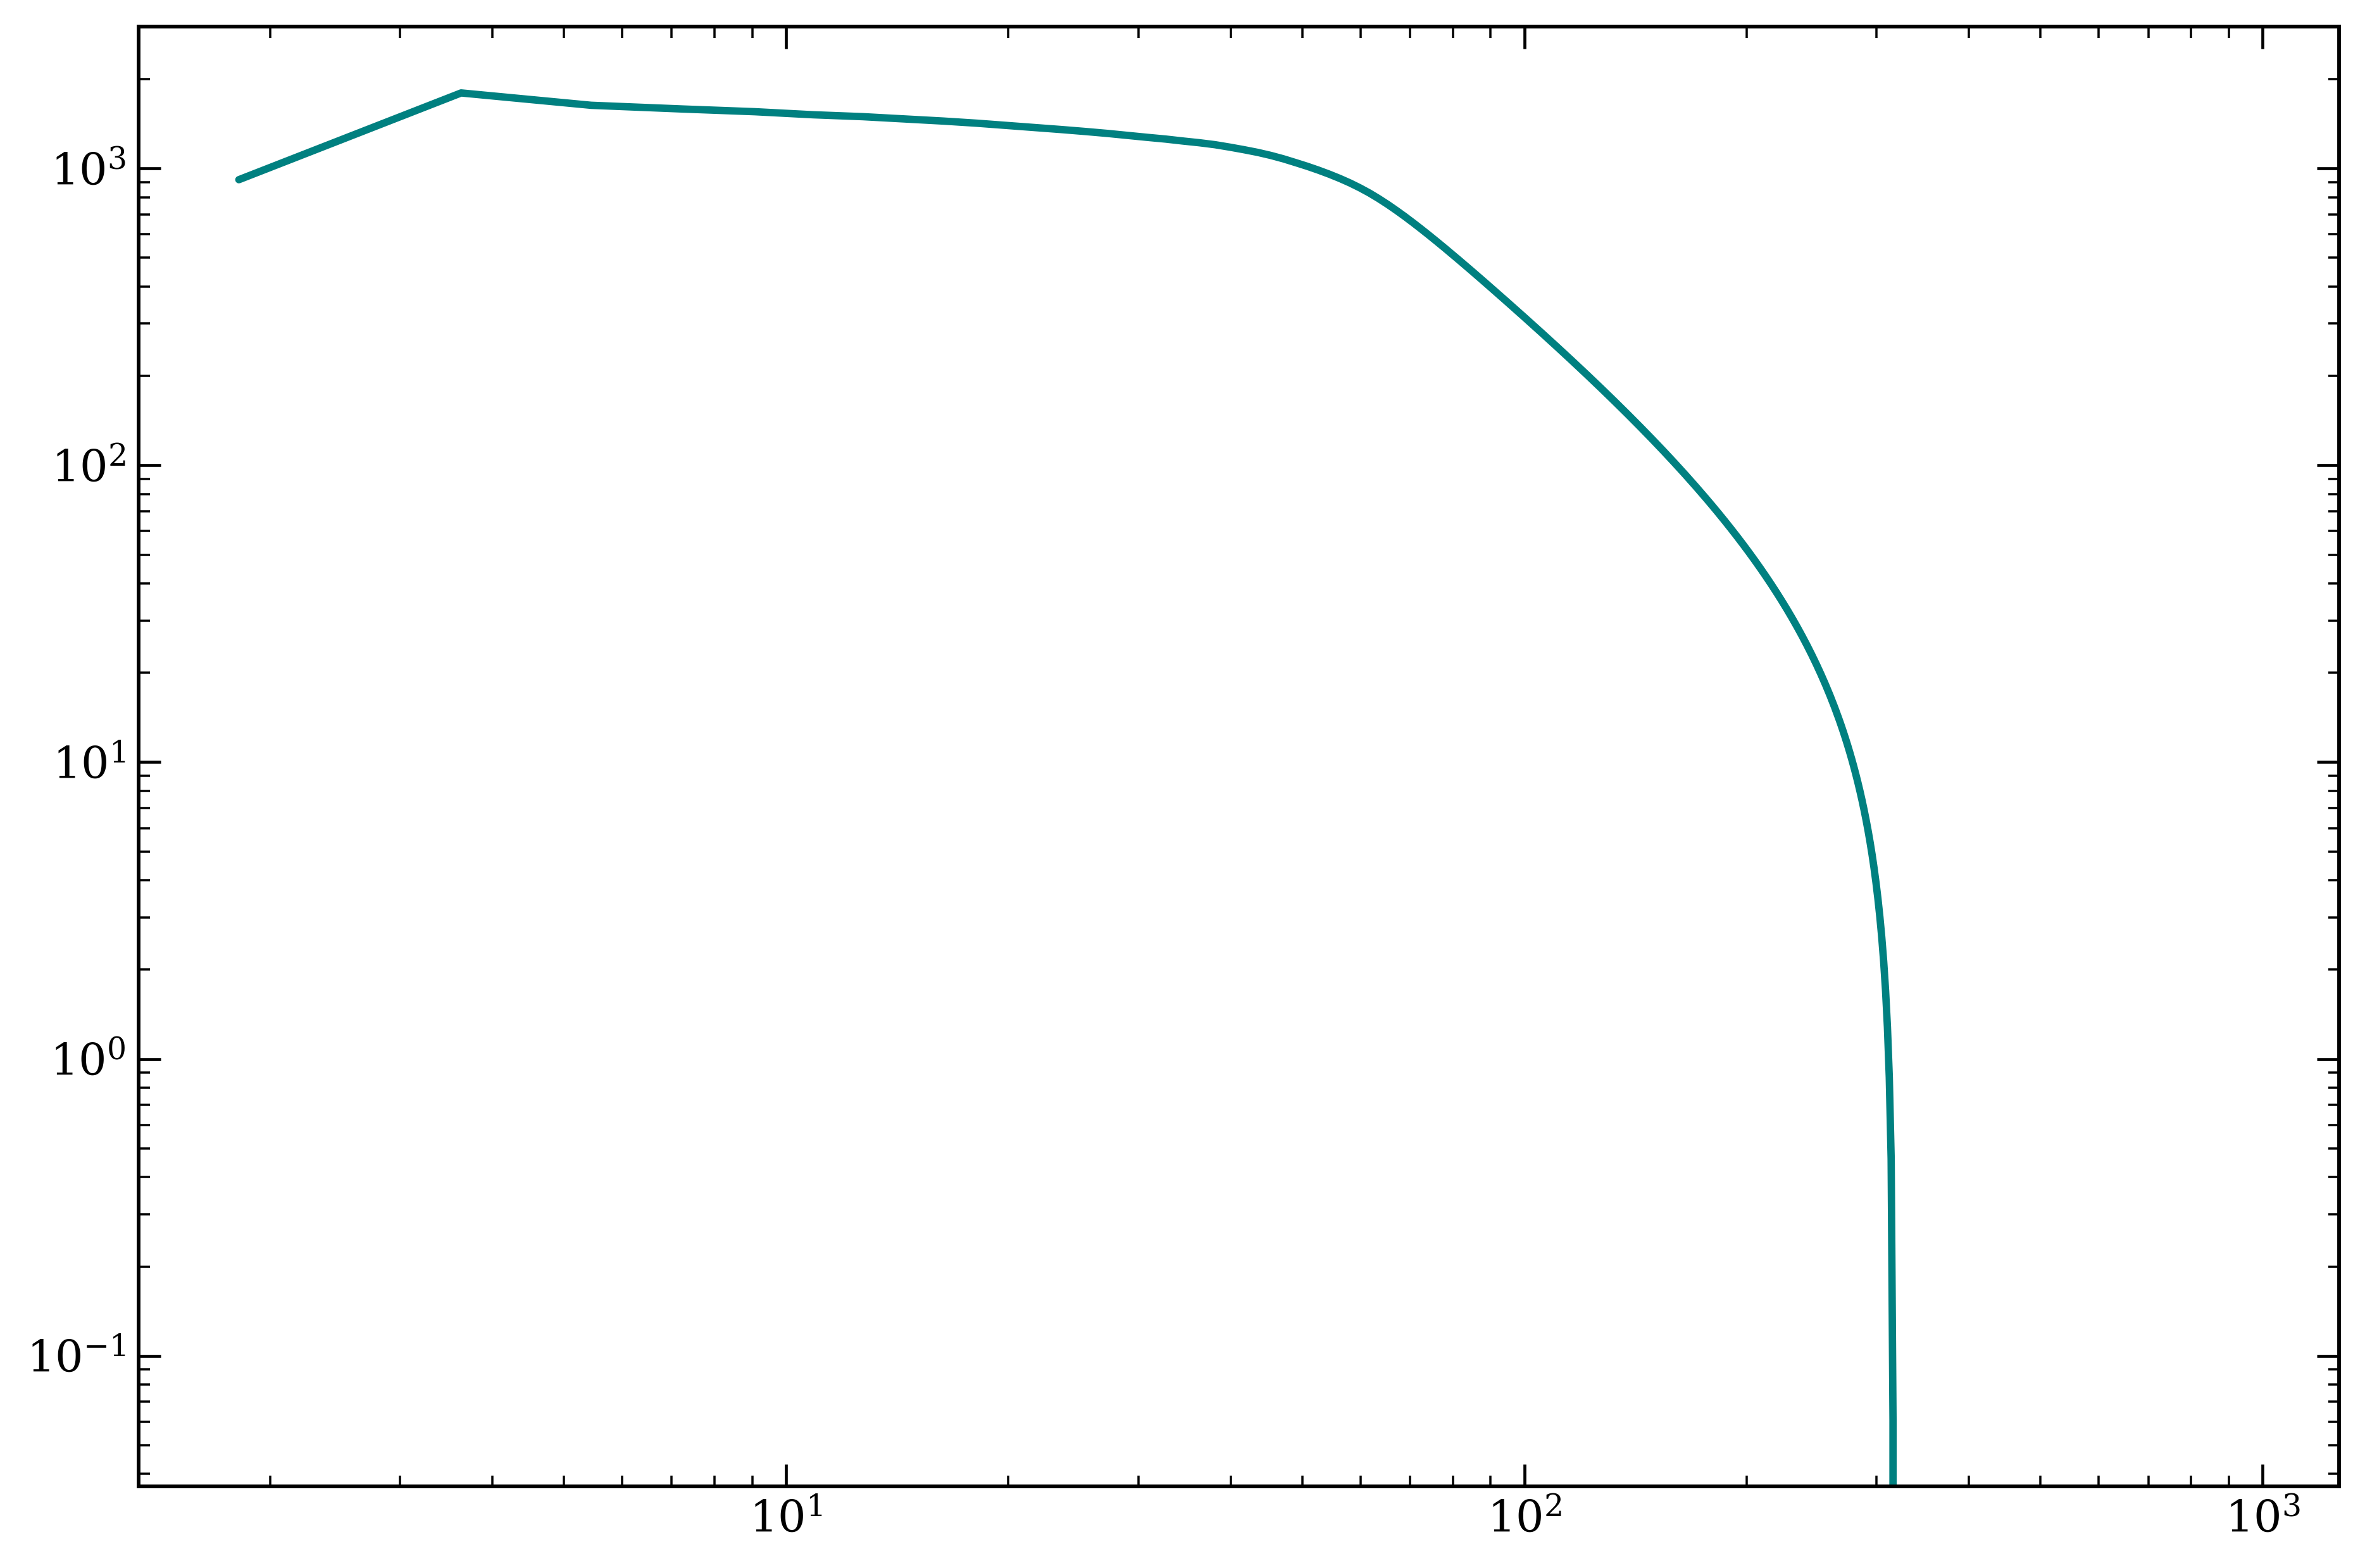

In [7]:
plt.plot(rad_arr, np.nanmean(pcf[:50,:], axis=0))
plt.xscale('log')
plt.yscale('log')

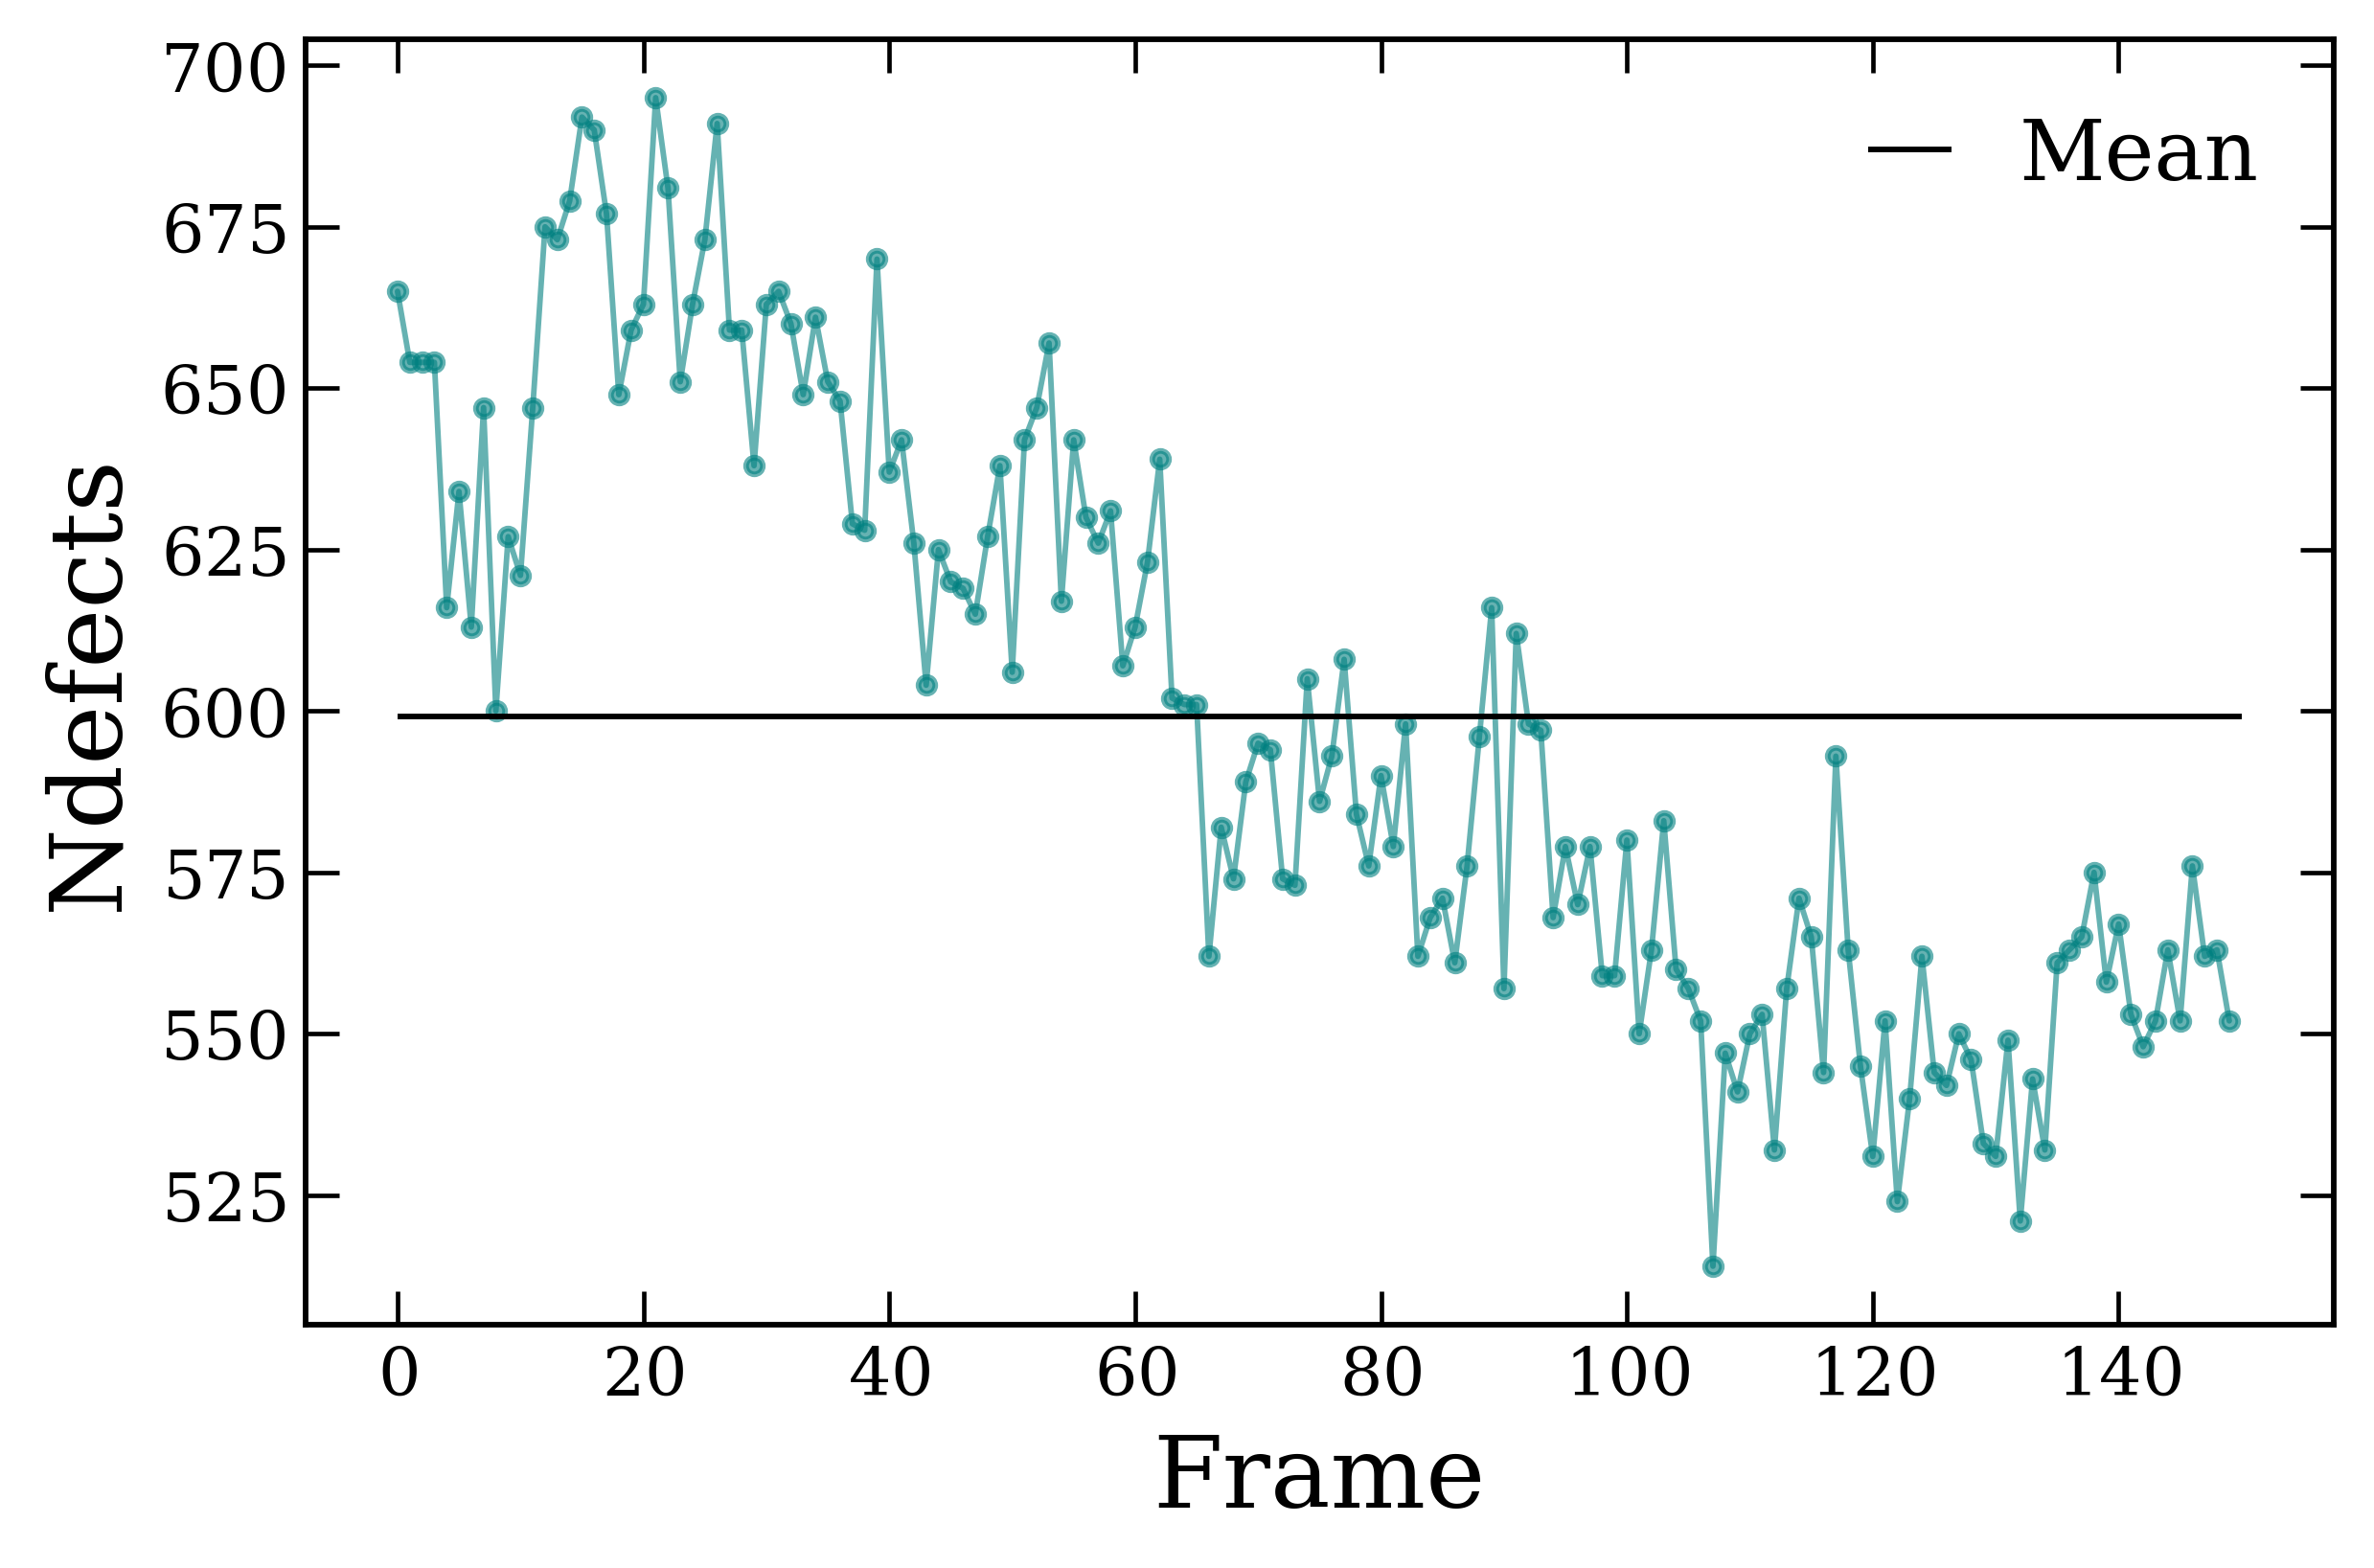

In [106]:
fig, ax = plt.subplots(figsize=(6, 4))
Nframes = len(defect_list)
Ndefects_av = Ndefects.mean()
ax.plot(np.arange(Nframes), Ndefects, marker='o', markersize=3, alpha=.6, lw=1,
        )

ax.hlines(Ndefects_av, 0, 150, ls='-',lw=1, color='k', label = 'Mean')
ax.set_xlabel('Frame')
ax.set_ylabel('Ndefects')
ax.legend()
fig.savefig(os.path.join(save_path, 'Ndefects.png'), dpi=420, bbox_inches='tight')

In [33]:
av_counts_av = np.nanmean(av_counts[:,:,0], axis=0)
av_var = np.nanvar(av_counts[:,:,0], axis = 0)
av_var_std = np.nanstd(av_counts[:,:,0], axis = 0)/  np.sqrt(av_var.shape[0])

In [3]:
def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]
    return x, Y0 * x**scaling_exp / x[0]**scaling_exp

In [ ]:
Nframes = len(defect_list)
window_idx_bounds=[20,50]

def fit_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
param_guess = np.array([2, .4])
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
Nparams = len(param_guess)

for i in range(3):

    fidx_bounds=[i * 50, i * 50 + 50]

    av_counts_av = np.nanmean(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis=0)
    av_var = np.nanvar(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0)
    av_var_std = np.nanstd(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0)/  np.sqrt(fidx_bounds[-1] - fidx_bounds[0])

    fit_params = np.zeros([3, 4]) * np.nan
    stat_arr = np.zeros([3,4]) * np.nan
    alpha_list = np.zeros([3,4]) * np.nan

    windows = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]

    av_counts_av = av_counts_av[window_idx_bounds[0]:window_idx_bounds[1]]
    count_var_av = av_var[window_idx_bounds[0]:window_idx_bounds[1],]
    count_var_std = av_var_std[window_idx_bounds[0]:window_idx_bounds[1],]

    zero_mask = (count_var_av > 0) & (count_var_std > 0)

    if len(count_var_av[zero_mask]) < 5:
        print('Not enough data points')
        continue

    try:
        x = np.log(windows[zero_mask])
        y = np.log(count_var_av[zero_mask])
        yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
    except:
        print('Not enough data points2')
        continue
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)


    #stat_arr[i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
    fit_params[i, :Nparams] = fit.values[:]
    fit_params[i, Nparams:] = fit.errors[:]

  #  X, Y = produce_scaling(window_sizes, 2-fit.values[0], 6 if i==1 else 10, [20,50])
    #plt.plot(X,Y, label=rf'$\alpha$ = {fit.values[0]:.3f} +/- {fit.errors[0]:.3f}', color=f'C{i}')

    #X, Y = produce_scaling(av_counts_av, 0.5, 3, [20,50])
    plt.plot(windows, count_var_av, '.-', color=f'C{i}',
             alpha=.6, label = f'Frames {i*50}-{2*i+50}')
    
    X, Y = produce_scaling(window_sizes, 2-fit.values[0], 6 if i==1 else 10, [20,50])
    plt.plot(X,Y, label=rf'$\alpha$ = {fit.values[0]:.3f} +/- {fit.errors[0]:.3f}', color=f'C{i}')

    #plt.errorbar(av_counts_av[:ridx_max], np.sqrt(av_var[:ridx_max]),
    #            np.sqrt(av_var_std[:ridx_max]), fmt= '.', color=f'C{i}',
    #            alpha=.6, zorder=-10,
    #            label = f'{i}')
    
#X, Y = produce_scaling(window_sizes, 2, 10, [20,50])
#plt.plot(X,Y, label='0.7')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(rf'Window size (R)')
plt.ylabel(rf'Defect count variation ($\sigma^2_N(R)$)')

plt.savefig(os.path.join(save_path, 'count_var.png'), dpi=420, bbox_inches='tight')

In [116]:
sfac[fidx_bounds[0]:fidx_bounds[1],:,0]

array([[0.64207905, 0.83802023, 1.46611085, ..., 1.57059405, 1.19988253,
        1.75278492],
       [0.38398819, 1.10773126, 1.08685876, ..., 1.10370715, 1.31717536,
        1.14835214],
       [1.42832721, 1.02055534, 1.08043584, ..., 1.21275973, 0.90432404,
        0.60196468],
       ...,
       [1.36570444, 1.3586732 , 1.51431108, ..., 1.32733759, 0.88522495,
        1.37667533],
       [1.6585699 , 1.19226911, 2.03793228, ..., 0.82176283, 1.34865178,
        1.37472514],
       [1.41309676, 0.96628646, 1.7330682 , ..., 1.30216559, 0.48905236,
        2.21621179]])

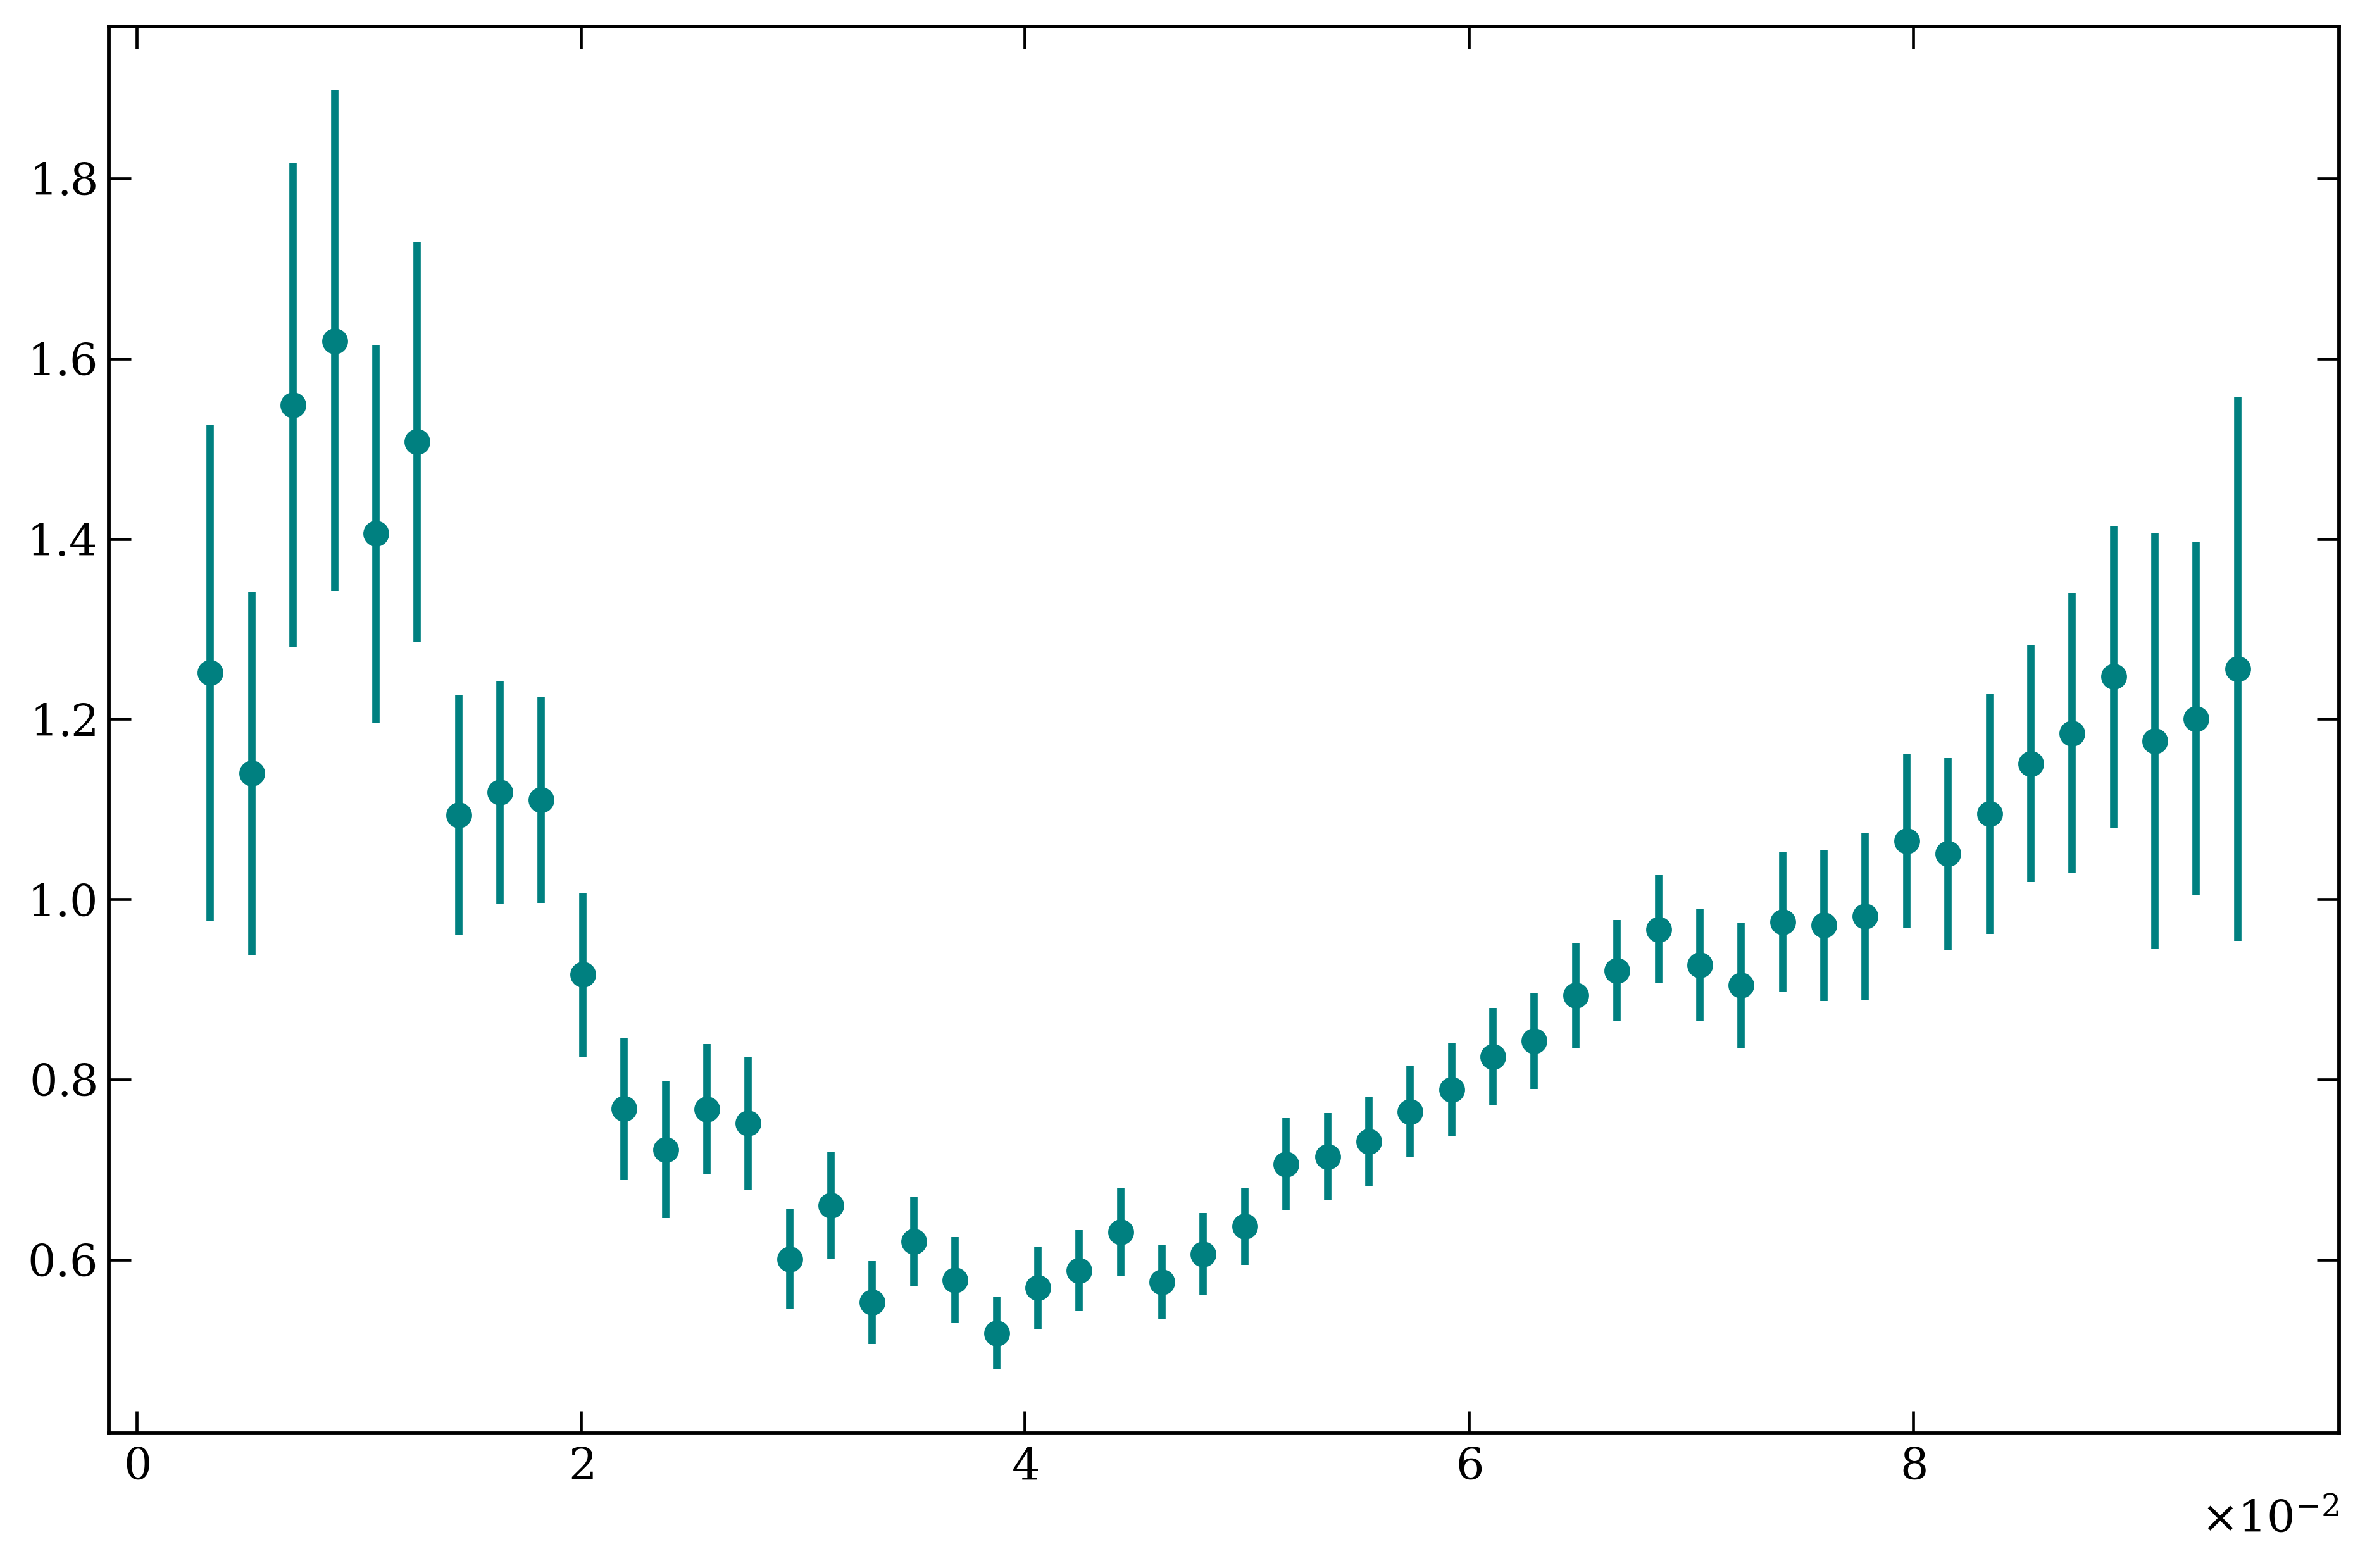

In [7]:
fidx_bounds = [101,150]
plt.errorbar(kbins,np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0), np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,1], axis = 0), fmt='o')
plt.savefig(os.path.join(save_path, f'sfac{fidx_bounds[0]}-{fidx_bounds[1]}.png'), dpi=420, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
Nframes = len(defect_list)
Ndefects_av = Ndefects.mean()
ax.plot(np.arange(Nframes), Ndefects, marker='o', markersize=3, alpha=.6, lw=1,
        )

ax.hlines(Ndefects_av, 0, 150, ls='-',lw=1, color='k', label = 'Mean')
ax.set_xlabel('Frame')
ax.set_ylabel('Ndefects')
ax.legend()
fig.savefig(os.path.join(save_path, 'Ndefects.png'), dpi=420, bbox_inches='tight')

In [ ]:
import pickle as pkl
for i, file in enumerate(os.listdir(data_dirs)):
    if file.endswith('.pkl'):
        print(f'Loading {file}')
        with open(os.path.join(data_dirs, file), 'rb') as f:
            data = pkl.load(f)
        print(len(data), len(data[-1]))
        if i == 0:
            all_data = data
        else:
            all_data.extend(data)

In [4]:
data_dict = {}
for i, file in enumerate(os.listdir(data_dirs)):
    if file.endswith('.csv'):
        key_name = file.split('.')[0]
        data_dict[key_name] = pd.read_csv(os.path.join(data_dirs, file),) # index_col=0)
        #data_dict[file]['time'] = pd.to_datetime(data_dict[file]['time'], format='%Y-%m-%d %H:%M:%S.%f')
        #data_dict[file].set_index('time', inplace=True)
        #data_dict[file].sort_index(inplace=True)

In [5]:
#df = pd.read_csv('30.csv')
key_list = list(data_dict.keys())
df = data_dict[key_list[0]]  # Change index to select different data file


df['X']  *= 2
df['Y']  *= 2
df['DX'] *= 2
df['DY'] *= 2

# sorted unique coords & times
x_coords = np.sort(df['X'].unique())
y_coords = np.sort(df['Y'].unique())
times    = np.sort(df['Slice'].unique())

nx, ny, nt = len(x_coords), len(y_coords), len(times)

# build index maps
ix_map = {x:i for i, x in enumerate(x_coords)}
iy_map = {y:j for j, y in enumerate(y_coords)}
t_map  = {t:k for k, t in enumerate(times)}

# allocate U,V
U = np.zeros((nx, ny, nt))
V = np.zeros((nx, ny, nt))

# fill
for _, row in df.iterrows():
    i = ix_map[row['X']]
    j = iy_map[row['Y']]
    k = t_map[row['Slice']]
    U[i, j, k] = row['DX']
    V[i, j, k] = row['DY']

# meshgrid for plotting (shape ny×nx)
Xg, Yg = np.meshgrid(x_coords, y_coords)

# Cell 3: Quick director‐field plot for one frame

In [ ]:
from matplotlib.collections import LineCollection

k = t_map[10]

# Recompute the nematic director segments for frame k
U_s, V_s = U[:,:,k], V[:,:,k]
phi = 0.5 * np.arctan2(2*U_s*V_s, U_s**2 - V_s**2)  # angle in [0, π)
L = min(x_coords[1]-x_coords[0], y_coords[1]-y_coords[0]) * 2
Phi = phi.T
dxs =  L * 0.1 * np.cos(Phi)
dys =  L * 0.1 * np.sin(Phi)

segments = [
    [[x0 - dx, y0 - dy], [x0 + dx, y0 + dy]]
    for x0, y0, dx, dy in zip(Xg.ravel(), Yg.ravel(), dxs.ravel(), dys.ravel())
]

lc = LineCollection(segments, colors='black', linewidths=1)

# Plot
mm = 1/25.4

fig, ax = plt.subplots(figsize=(48*mm, 48*mm), dpi=300)
ax.add_collection(lc)

ax.set_xlim(x_coords.min(), x_coords.max())
ax.set_ylim(y_coords.min(), y_coords.max()) 
ax.set_aspect('equal')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.legend(loc='upper right')
plt.show()

# Cell 4: Define topological‐defect detection

In [19]:
def get_charge(vx, vy, LX, LY):
    """Compute winding charge at each grid point."""
    def wang(a, b):
        ang = np.arctan2(a[0]*b[1] - a[1]*b[0],
                         a[0]*b[0] + a[1]*b[1])
        return np.where(np.abs(ang) > .5*np.pi,
                         ang - np.sign(ang)*np.pi,
                         ang)
    v = np.stack([vx, vy]).reshape(2, LX, LY)
    w = np.zeros((LX, LY))
    shifts = [(1,0),(1,1),(0,1),(-1,1),
              (-1,0),(-1,-1),(0,-1),(1,-1),(1,0)]
    for s0, s1 in pairwise(shifts):
        v0 = np.roll(v, shift=s0, axis=(1,2))
        v1 = np.roll(v, shift=s1, axis=(1,2))
        w += wang(v0, v1)
    return w / (2*np.pi)

def get_defects(vx, vy, LX, LY, threshold=.4):
    """
    Return list of {'charge':±0.5, 'pos':(i,j)}
    in index‐space whenever |winding|>threshold.
    """
    w = get_charge(vx, vy, LX, LY)
    def collapse(root, s):
        w[root] = 0.0
        queue = [root]; detected = [root]
        while queue:
            i,j = queue.pop(0)
            for di,dj in [(1,0),(-1,0),(0,1),(0,-1)]:
                ni, nj = (i+di)%LX, (j+dj)%LY
                if s*w[ni,nj] > threshold and (ni,nj) not in detected:
                    detected.append((ni,nj))
                    queue.append((ni,nj))
                    w[ni,nj] = 0.0
        x_mean, y_mean = np.mean(detected, axis=0)
        return x_mean % LX, y_mean % LY

    defects = []
    for idx in np.ndindex(w.shape):
        if abs(w[idx]) > threshold:
            s = np.sign(w[idx])
            xij, yij = collapse(idx, s)
            defects.append({'charge': 0.5*s, 'pos': (xij, yij)})
    return defects

# Cell 5: Detect +½/–½ defects for every frame & convert to physical coords

In [ ]:
plus_defects  = []   # list of (n_i,2) arrays of X,Y
minus_defects = []
defect_list = []

ix = np.arange(nx)
iy = np.arange(ny)

for k in range(nt):
    raw = get_defects(U[:,:,k], V[:,:,k], nx, ny, threshold=0.4)
    if not raw:
        plus_defects.append(np.empty((0,2)))
        minus_defects.append(np.empty((0,2)))
        continue
    defect_list.append(raw) 

    if 0:
        pos_idx = np.array([d['pos'] for d in raw])
        ch      = np.array([d['charge'] for d in raw])
        x_phys  = np.interp(pos_idx[:,0], ix, x_coords)
        y_phys  = np.interp(pos_idx[:,1], iy, y_coords)

        plus_defects.append(  np.column_stack([x_phys[ch>0], y_phys[ch>0]]) )
        minus_defects.append( np.column_stack([x_phys[ch<0], y_phys[ch<0]]) )

# Cell 6 (revised): Overlay defects on the nematic director field

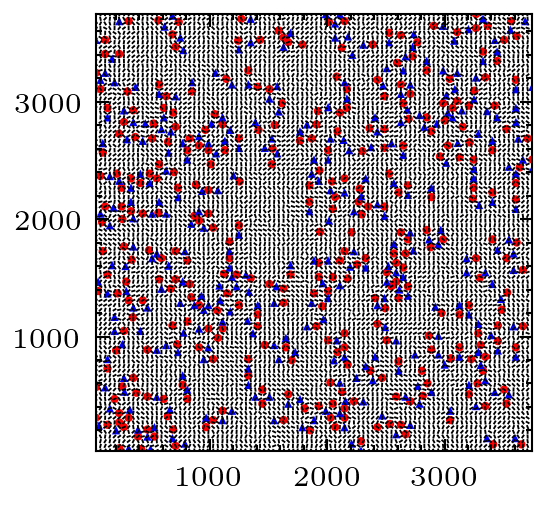

In [36]:
from matplotlib.collections import LineCollection
import scienceplots
plt.style.use('science')

k = t_map[10]

# Recompute the nematic director segments for frame k
U_s, V_s = U[:,:,k], V[:,:,k]
phi = 0.5 * np.arctan2(2*U_s*V_s, U_s**2 - V_s**2)  # angle in [0, π)
L = min(x_coords[1]-x_coords[0], y_coords[1]-y_coords[0]) * 2
Phi = phi.T
dxs =  L * 0.1 * np.cos(Phi)
dys =  L * 0.1 * np.sin(Phi)

segments = [
    [[x0 - dx, y0 - dy], [x0 + dx, y0 + dy]]
    for x0, y0, dx, dy in zip(Xg.ravel(), Yg.ravel(), dxs.ravel(), dys.ravel())
]

lc = LineCollection(segments, colors='black', linewidths=1)

# Plot
mm = 1/25.4

fig, ax = plt.subplots(figsize=(48*mm, 48*mm), dpi=300)
ax.add_collection(lc)

# Plot +1/2 defects: red filled circles
if plus_defects[k].size:
    ax.scatter(
        plus_defects[k][:,0], plus_defects[k][:,1],
        c='red', marker='o', s=4, label='+½', edgecolors='none'
    )

# Plot -1/2 defects: blue filled triangles
if minus_defects[k].size:
    ax.scatter(
        minus_defects[k][:,0], minus_defects[k][:,1],
        c='blue', marker='^', s=4, label='−½', edgecolors='none'
    )

ax.set_xlim(x_coords.min(), x_coords.max())
ax.set_ylim(y_coords.min(), y_coords.max()) 
ax.set_aspect('equal')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.legend(loc='upper right')
plt.show()

# Cell 7: ⟨Structure factor S(k)⟩ over all frames → divergence test

/var/folders/cb/scnh6zzn3wb9s4gmkvv99llm0000gn/T/ipykernel_23161/2558180663.py:32: RuntimeWarning: divide by zero encountered in matmul
  S2d[i,j] = np.abs(np.sum(np.exp(-1j * (pts @ kv))))**2 / N
/var/folders/cb/scnh6zzn3wb9s4gmkvv99llm0000gn/T/ipykernel_23161/2558180663.py:32: RuntimeWarning: overflow encountered in matmul
  S2d[i,j] = np.abs(np.sum(np.exp(-1j * (pts @ kv))))**2 / N
/var/folders/cb/scnh6zzn3wb9s4gmkvv99llm0000gn/T/ipykernel_23161/2558180663.py:32: RuntimeWarning: invalid value encountered in matmul
  S2d[i,j] = np.abs(np.sum(np.exp(-1j * (pts @ kv))))**2 / N


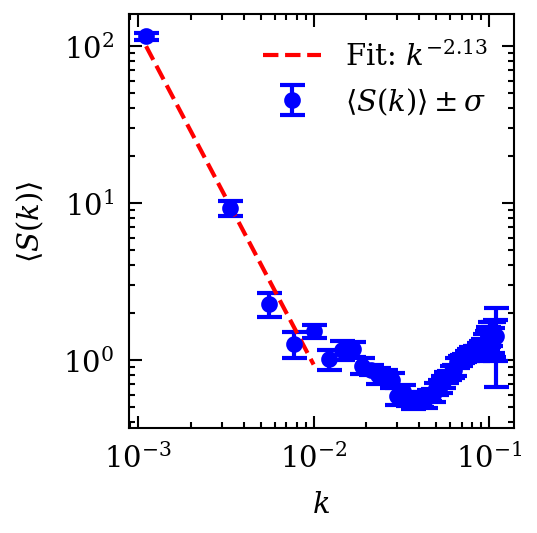

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

# 1) Precompute the k‐grid
Lx, Ly    = np.ptp(x_coords), np.ptp(y_coords)
dx, dy    = x_coords[1] - x_coords[0], y_coords[1] - y_coords[0]
dk        = 2 * np.pi / max(Lx, Ly)
kx        = np.arange(-np.pi/dx, np.pi/dx, dk)
ky        = np.arange(-np.pi/dy, np.pi/dy, dk)
KX, KY    = np.meshgrid(kx, ky)
Nkx, Nky  = KX.shape

# 2) Define radial bins
nbins     = 50
kr        = np.hypot(KX, KY).ravel()
bins      = np.linspace(0, kr.max(), nbins+1)
centers   = 0.5 * (bins[:-1] + bins[1:])

# 3) Accumulate S2d for each frame
S_accum = np.zeros((nt, Nkx, Nky))
for idx in range(nt):
    pts = np.vstack([plus_defects[idx], minus_defects[idx]])
    N   = len(pts)
    S2d = np.zeros_like(KX)
    if N > 0:
        for i in range(Nkx):
            for j in range(Nky):
                kv        = np.array([KX[i,j], KY[i,j]])
                S2d[i,j] = np.abs(np.sum(np.exp(-1j * (pts @ kv))))**2 / N
    S_accum[idx] = S2d

# 4) Radially average each frame → S_frame[idx, m]
S_frame = np.zeros((nt, nbins))
for idx in range(nt):
    flat = S_accum[idx].ravel()
    for m in range(nbins):
        mask = (kr >= bins[m]) & (kr < bins[m+1])
        if np.any(mask):
            S_frame[idx, m] = flat[mask].mean()

# 5) Compute mean and std over frames
S_k     = S_frame.mean(axis=0)
S_std   = S_frame.std(axis=0)

# 6) Choose low‐k fitting window (first 10% of nonzero k’s)
kvals    = centers
nonzero  = kvals > 0
fraction = 0.1
mask_k   = nonzero & (kvals < np.percentile(kvals[nonzero], fraction*100))

# 7) Fit γ in ⟨S(k)⟩ ∝ k^γ
gamma, intercept = np.polyfit(np.log(kvals[mask_k]), np.log(S_k[mask_k]), 1)

# 8) Plot with error bars and fit
mm = 1/25.4
fig, ax = plt.subplots(figsize=(48*mm, 48*mm), dpi=300)
# Error bars
ax.errorbar(
    centers, S_k, yerr=S_std, fmt='o', capsize=3, color='blue'
    , label=r'$\langle S(k) \rangle \pm \sigma$'
)
# Fit line
ax.plot(
    kvals[mask_k],
    np.exp(intercept) * kvals[mask_k] ** gamma,
    'r--',
    label=fr'Fit: $k^{{{gamma:.2f}}}$'
)
# Log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and legend
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\langle S(k) \rangle$')
ax.legend()
fig.tight_layout()
plt.show()

# Cell 8: ⟨Number‐variance σ²(R)⟩ over all frames → growth exponent α

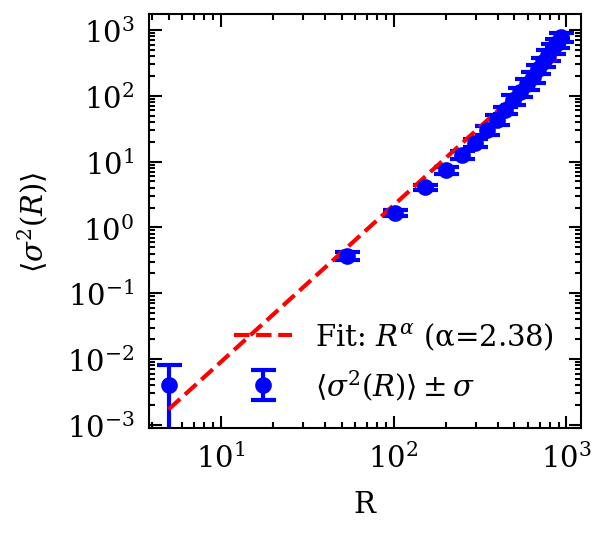

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

def number_variance(pts, R, n_samples=200):
    counts = []
    xmin, xmax = x_coords.min(), x_coords.max()
    ymin, ymax = y_coords.min(), y_coords.max()
    for _ in range(n_samples):
        x0 = random.uniform(xmin, xmax)
        y0 = random.uniform(ymin, ymax)
        counts.append(((pts[:,0]-x0)**2 + (pts[:,1]-y0)**2 < R**2).sum())
    return np.var(counts), np.mean(counts)

# 1) Define R values and accumulate variances
Rs         = np.linspace(5, min(Lx, Ly)/4, 20)
vars_accum = np.zeros((nt, len(Rs)))

for idx in range(nt):
    pts = np.vstack([plus_defects[idx], minus_defects[idx]])
    for i, R in enumerate(Rs):
        v, _ = number_variance(pts, R, n_samples=200)
        vars_accum[idx, i] = v

# 2) Compute mean and std over frames
vars_mean = vars_accum.mean(axis=0)
vars_std  = vars_accum.std(axis=0)

# 3) Fit α in ⟨σ²(R)⟩ ∝ R^α
alpha, intercept = np.polyfit(np.log(Rs), np.log(vars_mean), 1)

# 4) Plot with error bars and fit
mm = 1/25.4
fig, ax = plt.subplots(figsize=(54*mm, 48*mm), dpi=300)
# Error bars
ax.errorbar(Rs, vars_mean, yerr=vars_std, fmt='o', capsize=3, color='blue',
            label=r'$\langle\sigma^2(R)\rangle \pm \sigma$')
# Fit line
ax.plot(
    Rs,
    np.exp(intercept) * Rs**alpha,
    'r--',
    label=fr'Fit: $R^{{\alpha}}$ (α={alpha:.2f})'
)
# Log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and legend
ax.set_xlabel('R')
ax.set_ylabel(r'$\langle\sigma^2(R)\rangle$')
ax.legend(loc='lower right')
fig.tight_layout()
plt.show()

# autocorrelation

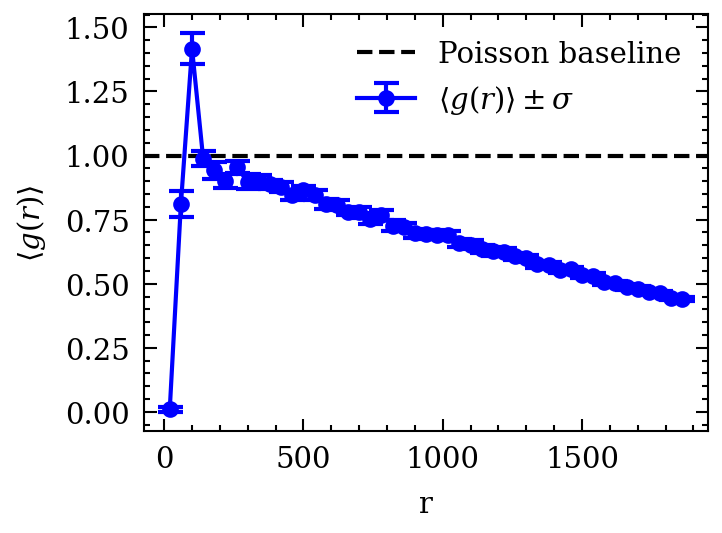

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

def radial_pair_correlation(pts, r_max, dr, area):
    """
    Compute g(r) for a set of points `pts` in a periodic box of given `area`.
    
    Parameters
    ----------
    pts : (N,2) array
      Defect positions.
    r_max : float
      Maximum radius to compute g(r).
    dr : float
      Bin width.
    area : float
      Total area of the domain.
    
    Returns
    -------
    r : (M,) array
      Bin centers.
    g : (M,) array
      Pair correlation g(r).
    """
    N = len(pts)
    if N < 2:
        # no pairs → zero everywhere
        bins = np.arange(0, r_max+dr, dr)
        r = 0.5*(bins[:-1] + bins[1:])
        return r, np.zeros_like(r)
    
    # all pairwise distances
    dists = pdist(pts)  # shape (N*(N-1)/2,)
    
    # histogram
    bins = np.arange(0, r_max+dr, dr)
    hist, _ = np.histogram(dists, bins=bins)
    r = 0.5*(bins[:-1] + bins[1:])
    
    # normalization factor for an ideal Poisson:
    # expected number of pairs in [r, r+dr]: 
    #   N * density * (2πr dr)
    density = N / area
    norm = N * density * 2 * np.pi * r * dr
    
    # convert histogram of pairs → g(r)
    # note: pdist counts each pair once, ideal gas counts each *ordered* pair,
    # so we divide norm by 2 to match unordered pairs:
    g = hist / (norm / 2)
    
    return r, g

# parameters
Lx, Ly = np.ptp(x_coords), np.ptp(y_coords)
area    = Lx * Ly
r_max   = min(Lx, Ly) / 2
dr      = min(x_coords[1]-x_coords[0], y_coords[1]-y_coords[0])  # one grid spacing

# collect g(r) from each frame
all_g = []
all_r = None

for idx in range(nt):
    pts = np.vstack([plus_defects[idx], minus_defects[idx]])  # (Ni,2)
    r, g = radial_pair_correlation(pts, r_max, dr, area)
    all_g.append(g)
    if all_r is None:
        all_r = r

all_g = np.vstack(all_g)
g_mean = all_g.mean(axis=0)
g_std  = all_g.std(axis=0)

# --- Create figure and axis ---
mm = 1/25.4
fig, ax = plt.subplots(figsize=(64*mm, 48*mm), dpi=300)
# --- Plot g(r) with error bars ---
ax.errorbar(all_r, g_mean, yerr=g_std, fmt='o-', capsize=3, color='blue',
            label=r'$\langle g(r) \rangle \pm \sigma$')

# --- Add Poisson baseline ---
ax.axhline(1, color='k', linestyle='--', label='Poisson baseline')

# --- Labeling ---
ax.set_xlabel('r')
ax.set_ylabel(r'$\langle g(r) \rangle$')
ax.legend()

# --- Layout and show ---
fig.tight_layout()
plt.show()

Fitted tail exponent β ≈ 0.99, prefactor A ≈ 3.34e-04


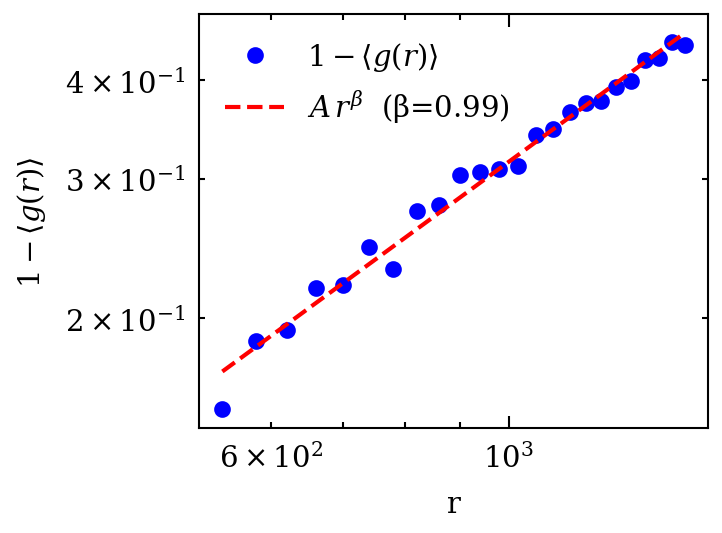

In [75]:
# Cell N+3: Power‐law fit of the long‐range tail (200 < r < 1000)

import numpy as np
import matplotlib.pyplot as plt

# 1) Select fit window
mask_fit = (all_r > 500) & (all_r < 1500)
r_fit    = all_r[mask_fit]
y_fit    = 1.0 - g_mean[mask_fit]   # deviation = 1 − ⟨g(r)⟩

# 2) Log–log linear regression: log(y_fit) = log(A) − β·log(r_fit)
slope, logA = np.polyfit(np.log(r_fit), np.log(y_fit), 1)
beta = slope                        # exponent
A    = np.exp(logA)                  # prefactor

print(f"Fitted tail exponent β ≈ {beta:.2f}, prefactor A ≈ {A:.2e}")

# 3) Plot data and model
mm = 1/25.4
fig, ax = plt.subplots(figsize=(64*mm, 48*mm), dpi=300)

ax.loglog(r_fit, y_fit, 'o', color='blue',
          label=r'$1 - \langle g(r)\rangle$')
ax.loglog(r_fit, A * r_fit**(beta), '--', color='red', 
          label=fr'$A\,r^{{\beta}}$  (β={beta:.2f})')

ax.set_xlabel('r')
ax.set_ylabel(r'$1 - \langle g(r)\rangle$')
ax.legend()

fig.tight_layout()
plt.show()

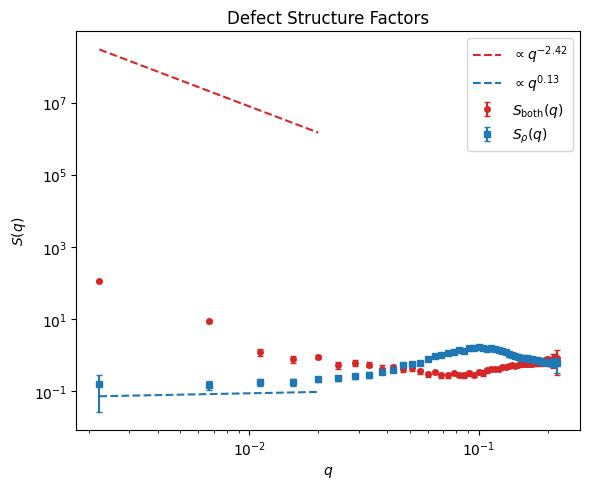

In [48]:
# Cell N+4: Defect structure factors Sboth(q) and Srho(q)

import numpy as np
import matplotlib.pyplot as plt

# --- 1) build q-grid ---
Lx, Ly = np.ptp(x_coords), np.ptp(y_coords)
dq     = 2 * np.pi / max(Lx, Ly)
qx     = np.arange(-np.pi/(x_coords[1]-x_coords[0]), np.pi/(x_coords[1]-x_coords[0]), dq)
qy     = np.arange(-np.pi/(y_coords[1]-y_coords[0]), np.pi/(y_coords[1]-y_coords[0]), dq)
QX, QY = np.meshgrid(qx, qy)
qgrid  = np.hypot(QX, QY)
nbins   = 50

# radial bins
qmax    = qgrid.max()
qb      = np.linspace(0, qmax, nbins+1)
q_cent  = 0.5*(qb[:-1] + qb[1:])

# containers
Sb_acc = np.zeros((nt, nbins))
Sr_acc = np.zeros((nt, nbins))

# loop frames
for k in range(nt):
    # positions
    p_plus  = plus_defects[k]
    p_minus = minus_defects[k]
    # Sboth uses all defects equally
    pts_both = np.vstack([p_plus, p_minus])
    N_both   = len(pts_both)

    # Srho uses charges ±1
    pts_rho  = pts_both
    ch       = np.hstack([np.ones(len(p_plus)), -np.ones(len(p_minus))])
    N_rho    = np.sum(ch**2)

    # compute FT sums on the grid
    Sb = np.zeros_like(QX, dtype=float)
    Sr = np.zeros_like(QX, dtype=float)
    if N_both>0:
        for (x,y) in pts_both:
            Sb += np.cos(QX*x + QY*y)  # real part, sum e^{-i q·r}
        Sb = (Sb**2 + 0.0) / N_both  # |sum|^2/N

    if len(pts_rho)>0:
        # weighted sum e^{-i q·r} with weights ch
        C = np.zeros_like(QX, dtype=complex)
        for (x,y), w in zip(pts_rho, ch):
            C += w * np.exp(-1j*(QX*x + QY*y))
        Sr = (np.abs(C)**2) / N_rho

    # radial binning
    flat_q   = qgrid.ravel()
    flat_Sb  = Sb.ravel()
    flat_Sr  = Sr.ravel()
    for m in range(nbins):
        mask = (flat_q >= qb[m]) & (flat_q < qb[m+1])
        if np.any(mask):
            Sb_acc[k, m] = flat_Sb[mask].mean()
            Sr_acc[k, m] = flat_Sr[mask].mean()

# average over frames
Sb_mean = Sb_acc.mean(axis=0)
Sr_mean = Sr_acc.mean(axis=0)
Sb_std  = Sb_acc.std(axis=0)
Sr_std  = Sr_acc.std(axis=0)

# fit low-q slopes (optional)
# e.g. use first 10% of nonzero q’s for each
mask_low = (q_cent>0) & (q_cent < np.percentile(q_cent[q_cent>0], 10))
gamma_b, _ = np.polyfit(np.log(q_cent[mask_low]), np.log(Sb_mean[mask_low]), 1)
gamma_r, _ = np.polyfit(np.log(q_cent[mask_low]), np.log(Sr_mean[mask_low]), 1)

# plot
plt.figure(figsize=(6,5))
plt.errorbar(q_cent, Sb_mean, yerr=Sb_std, fmt='o', capsize=2, ms=4,
             label=r'$S_{\rm both}(q)$', color='tab:red')
plt.errorbar(q_cent, Sr_mean, yerr=Sr_std, fmt='s', capsize=2, ms=4,
             label=r'$S_{\rho}(q)$', color='tab:blue')

# guide-to-the-eye power laws
plt.loglog(q_cent[mask_low], np.exp(np.log(Sb_mean[mask_low][0])) * q_cent[mask_low]**gamma_b,
           '--', color='tab:red',  label=fr'$\propto q^{{{gamma_b:.2f}}}$')
plt.loglog(q_cent[mask_low], np.exp(np.log(Sr_mean[mask_low][0])) * q_cent[mask_low]**gamma_r,
           '--', color='tab:blue', label=fr'$\propto q^{{{gamma_r:.2f}}}$')

plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$q$'); plt.ylabel(r'$S(q)$')
plt.title('Defect Structure Factors')
plt.legend(loc='best')
plt.tight_layout()
plt.show()